In [1]:
from ltn_imp.automation.knowledge_base import KnowledgeBase

# Download and Prepare Datasets

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split

def prepare_datasets():
    poker_hand = fetch_ucirepo(id=158)   
    X = poker_hand.data.features 
    y = poker_hand.data.targets 
    data = pd.DataFrame(X, columns=poker_hand.data.feature_names)
    data["Label"] = y
    X_train, X_test = train_test_split(data, test_size=0.5, random_state=42, stratify=y)
    X_train, X_Val = train_test_split(X_train, test_size=0.1, random_state=42)
    X_train.to_csv("datasets/train.csv", index=False)
    X_Val.to_csv("datasets/val.csv", index=False)
    X_test.to_csv("datasets/test.csv", index=False)

In [3]:
import os
if "datasets" not in os.listdir():
    os.mkdir("datasets")
    prepare_datasets()
else:
    print("Datasets already exists")

Datasets already exists


# Visualize Dataset

In [4]:
train = pd.read_csv("datasets/train.csv")
val = pd.read_csv("datasets/val.csv")
test = pd.read_csv("datasets/test.csv")
data = pd.concat([train, val, test])
print(train.shape)
print(val.shape)
print(test.shape)

(461254, 11)
(51251, 11)
(512505, 11)


<Axes: xlabel='Label'>

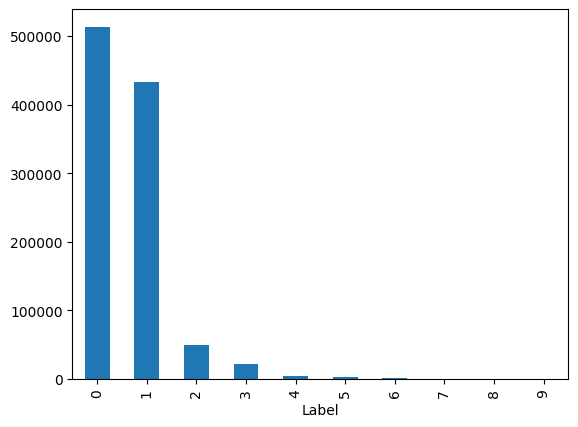

In [5]:
data["Label"].value_counts().plot(kind='bar')

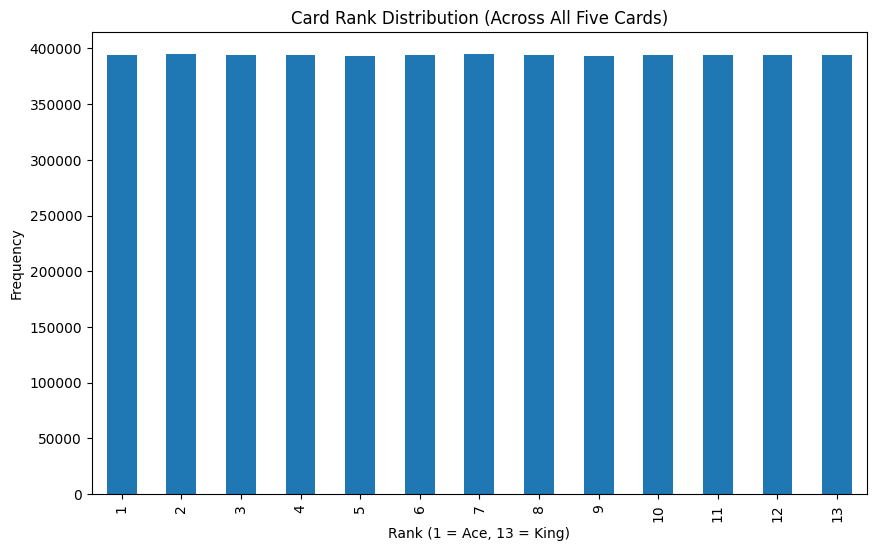

In [6]:
import matplotlib.pyplot as plt
ranks = pd.concat([data['C1'], data['C2'], data['C3'], data['C4'], data['C5']])

# Plot rank distribution
plt.figure(figsize=(10,6))
ranks.value_counts().sort_index().plot(kind='bar')
plt.title('Card Rank Distribution (Across All Five Cards)')
plt.xlabel('Rank (1 = Ace, 13 = King)')
plt.ylabel('Frequency')
plt.show()

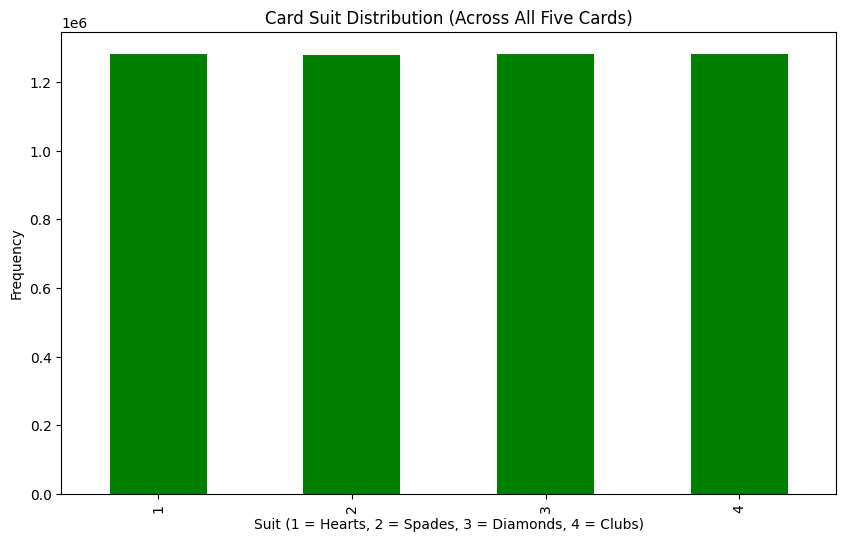

In [7]:
suits = pd.concat([data['S1'], data['S2'], data['S3'], data['S4'], data['S5']])

# Plot suit distribution
plt.figure(figsize=(10,6))
suits.value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Card Suit Distribution (Across All Five Cards)')
plt.xlabel('Suit (1 = Hearts, 2 = Spades, 3 = Diamonds, 4 = Clubs)')
plt.ylabel('Frequency')
plt.show()

# Optimize 

In [8]:
import torch
torch.backends.mps.is_available()

True

In [9]:
kb = KnowledgeBase("config.yaml", device="mps")

Using device: mps


In [10]:
import numpy as np 
import torch

def compute_accuracy(loader, model, num_classes, device):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for data, labels in loader:
        # Move data and labels to CPU
        data = data.to(device)
        labels = labels.cpu()

        # Get predictions and move them to CPU
        predictions = model(data).detach().cpu().numpy()
        predictions = np.argmax(predictions, axis=1)
        predictions = torch.tensor([ [float(p)] for p in predictions ]).numpy()
        
        labels = labels.numpy() 
        
        for i in range(num_classes):
            class_mask = (labels == i)
            class_correct[i] += np.sum(predictions[class_mask] == labels[class_mask])
            class_total[i] += np.sum(class_mask)

    class_accuracy = class_correct / class_total

    # Print accuracy for each class
    for i in range(num_classes):
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')

    # Compute and print general accuracy
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f'Overall accuracy: {overall_accuracy:.2f}')


In [11]:
compute_accuracy(kb.loaders[0], kb.predicates["PokerHand"], 10, kb.device)

KeyboardInterrupt: 

In [ ]:
# compute_accuracy(kb.test_loaders[0], kb.predicates["PokerHand"], 10, kb.device)

In [ ]:
kb.optimize(num_epochs=51, log_steps=10)

In [ ]:
compute_accuracy(kb.loaders[0], kb.predicates["PokerHand"], 10,kb.device)

In [ ]:
# compute_accuracy(kb.test_loaders[0], kb.predicates["PokerHand"], 10,kb.device)

# Evaluate